In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import multiprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from statistics import pstdev

# PREDICTING SUCCESS OF NORTH AMERICAN VIDEO GAME SALES

## Table Of Contents
1. [Understanding and Preparing](#preprocess)
3. [Visualizing the Data](#visualize)
4. [Correlation of Features](#correlation)
5. [Training our NaiveBayes Model](#trainingModel0)

## Understanding and Preparing the Data <a name="preprocess"></a>

First we read the data which is in a csv file into a dataframe,

In [3]:
## base_vgs_df ==== Base Video Game Sales DataFrame

base_vgs_df = pd.read_csv('../VideoGameSalesProject2021/Video_Games_Sales_as_at_22_Dec_2016.csv')

base_vgs_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#total number of video games in base_vgs_df

base_vgs_df['Platform'].size

16719

Here we can see what our data looks like. Each individual row represents one video games and its attributes include,

- Name                
- Platform           
- Year_of_Release    
- Genre              
- Publisher       
- NA_Sales              
- EU_Sales              
- JP_Sales         
- Other_Sales      
- Global_Sales        
- Critic_Score   
- Critic_Count   
- User_Score 
- User_Count   
- Developer       
- Rating  

NOTE: We briefly searched and cleaned the categorical attributes in the csv file before reading it into a dataframe, for example we replaced values such as 'Unknown' and 'None' as these were supposed to be NA data points.

Then we check for the rest of the missing or incorrect values and get an idea of the contents in each of the columns.

In [4]:
## checking for missing values by adding up all missing values in each column
base_vgs_df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher           255
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

We see that the columns, Critic_Score, Critic_Count, User_Score, and User_Count are all missing for more than 50% of the games and Developer/Rating are also missing a large number of values. There are also more problems with the numerical attributes then just missing values so we took a look at each columns' distribution, minimums, and maximums.

In [7]:
base_vgs_df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,7.125046,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,1.500006,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


Upon inspection we see that the max value in Year_of_Release is 2020, which must be pre-release or something of that nature. This data set was recorded and published in 2016 so are going to only look at video games made in 2016 or earlier.

We also see that there is a large difference between the max of columns NA_Sales, EU_Sales, JP_Sales, Other_Sales and Global_Sales and the rest of the data points in each of these columns suggestin that is may have an exponential distribution.

Another important thing to note is that these numbers appear to be in millions according to source of this data set. 

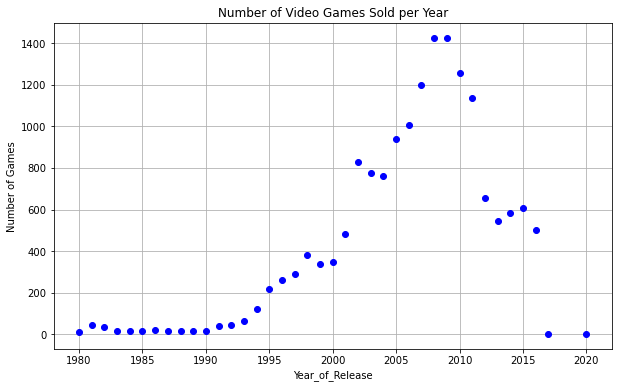

In [18]:
##graph the number of games released per year
num_games_per_year = base_vgs_df.groupby("Year_of_Release")['dummy'].count()

plt.figure(figsize=(10, 6))

plt.plot(num_games_per_year, 'bo')
plt.ylabel('Number of Games')
plt.xlabel('Year_of_Release')
plt.title('Number of Video Games Sold per Year')
plt.grid()

We can see that there were only a couple games with a date of release after 2016 so we will drop these values. 

An important thing to note when considering these video game sales is what consoles were being released at the time. We agreed that if we want to find the most accurate predictors of NA sales in the future we should look data is the immediate past as the video gaming seen has changed drastically from when it started. But where do we start? We see a peak near 2008, this was when the Wii, Xbox 360, and Playstation 3 came out. These consoles are slowly going out of fashion so let's drop games released after these consoles came out. In 2009 we start to see a decline in console games which is certaintly a trend that is most important for us to capture.

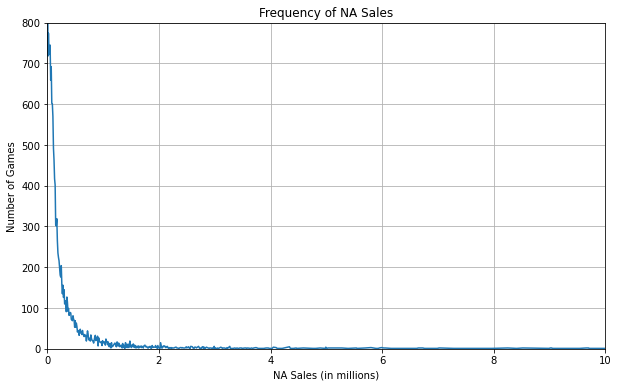

In [26]:
#create a dataframe of video games released between the years 2009-2016 (inclusive) then look at the frequency of NA sales

#create a dummy column to help count total number of video games
base_vgs_df['dummy'] = np.ones(base_vgs_df['Platform'].size)

#drop rows released before 2009 and after 2016 and return a dataframe
post_2009_vgs_df = pd.concat([base_vgs_df.loc[base_vgs_df['Year_of_Release'] >= 2009,:],base_vgs_df.loc[base_vgs_df['Year_of_Release'] < 2017,:]])

freq_NA_sales = post_2009_vgs_df.groupby("NA_Sales")['dummy'].count()

plt.figure(figsize=(10, 6))

plt.plot(freq_NA_sales)
plt.ylabel('Number of Games')
plt.xlabel('NA Sales (in millions)')
plt.title('Frequency of NA Sales')
plt.xlim(0, 10)
plt.ylim(0,800)
plt.grid()

Here we see the frequency of NA Sales is super high close to 0 and is very small anywhere beyond 2. We can see that this is an exponential distribution so a log transform could be useful if trying to normalize this data. Assuming that the games that sold zero copies in North America are the ones that are 0.00, we can drop these values.


## Visualization <a name="visualize"></a>

In order to visualize the data we made all the changes listed below. Here is what they are,

- Drop columns that are missing over 50% of the values i.e. Critic_score, critic_count, User_Score, User_Count, and Rating

- Drop rows with missing values in any column that is not one of the ones listed above

- Drop all rows with the Year_of_Release below or above the range 2009-2016

- Drop rows where NA_Sales == 0.00

- (Optional) Normalize NA_Sales as it shows an exponential distribution

In [37]:
# get rid of columns missing over 50% of values and get rid of all remaining rows contained a null value
std_vgs_df = base_vgs_df.dropna(axis=1, thresh = 9000).dropna().reset_index(drop = True)

# drop video games release before or after 2009-1016
std_vgs_df = std_vgs_df[std_vgs_df.Year_of_Release > 2008.0]
std_vgs_df = std_vgs_df[std_vgs_df.Year_of_Release < 2017.0]

# drop video games that did not sell in North America (NA_Sales == 0.00)
std_vgs_df = std_vgs_df[std_vgs_df.NA_Sales != 0.00].reset_index(drop = True)

# add a column that is the log transform of the NA_Sales column
std_vgs_df['Normalized_NA_Sales'] = np.log(std_vgs_df['NA_Sales'])

std_vgs_df['dummy'].size

3616

In [43]:
std_vgs_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Rating,dummy,Normalized_NA_Sales
0,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo,E,1.0,2.747912
1,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,Nintendo,E,1.0,2.670002
2,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,Good Science Studio,E,1.0,2.708050
3,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,Nintendo,E,1.0,2.198335
4,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,Rockstar North,M,1.0,1.948763


With our data now properly cleaned we are left with 3616 video games to use to train our model. Unfortunately this is ~1/5 of the original sample size but the adjustments we made were necessary. 

We decided that we wanted to use a Gaussian Naive Bayes Model to help us predict whether or not a video game will be successful in North America. To define success, we create a column and assign either 0 or 1 to each game. Video games that had sales worse than 50% of all video will be assigned 0 while video games that had sales in the top 50% of video games will be assigned a 1. This is the column we will use to test a video games success. 

The attributes that we decide to use as predicters of NA_Sales success are,

- Platform
- Genre
- Publisher
- Developer

We will create visualiztions for each of these attributes in order to better understand our data.

In [28]:
std_vgs_df['Platform'].unique()

array(['Wii', 'X360', 'PS3', '3DS', 'PS4', 'PC', 'WiiU', 'DS', 'XOne',
       'PSP', 'PS2', 'PSV'], dtype=object)

We decided that in order to visualize how platforms performed, we could group different platforms together by their creators,

In [44]:
## create general platform column

std_vgs_df['General_Platform']= base_vgs_df['Platform']

std_vgs_df.loc[std_vgs_df['Platform'] == 'PS3', 'General_Platform'] =  'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS', 'General_Platform'] = 'Sony_Playstation' 
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS2', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS4', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PSP', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PSV', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'Wii', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'DS', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'GBA', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == '3DS', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'WiiU', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'NES', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'X360', 'General_Platform'] = 'Microsoft_Xbox'
std_vgs_df.loc[std_vgs_df['Platform'] == 'XOne', 'General_Platform'] = 'Microsoft_Xbox'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PC', 'General_Platform'] = 'PC'

Now that we have our General_Platform column, we use it to make three unique graphs,

- Number of Games Produced by General Platform Per Year
- Sum of North American Sales By General Platforms Per Year
- Average Sales per Game by General Platform Per Year

Text(0.5, 0, 'Year of Release')

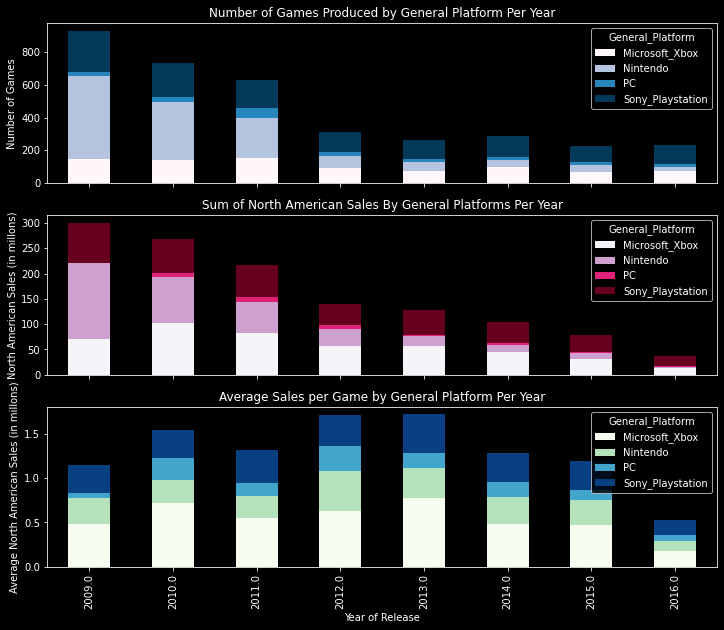

In [46]:
plt.style.use('dark_background')

#create df that is grouped by Year_of_Release and General_Platform then sum NA_Sales and dummy.
temp_df = std_vgs_df.groupby(['Year_of_Release', 'General_Platform'])[['dummy','NA_Sales']].sum()
temp_df['avg_sales'] = temp_df['NA_Sales'].div(temp_df['dummy'])



fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

temp_df['dummy'].unstack().plot(ax= axes[0],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'PuBu')

temp_df['NA_Sales'].unstack().plot(ax= axes[1],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'PuRd')

temp_df['avg_sales'].unstack().plot(ax= axes[2],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'GnBu')

axes[0].set_title('Number of Games Produced by General Platform Per Year')
axes[0].set_ylabel('Number of Games')
axes[0].set_xlabel('Year of Release')
axes[1].set_title('Sum of North American Sales By General Platforms Per Year')
axes[1].set_ylabel('North American Sales (in millons)')
axes[1].set_xlabel('Year of Release')
axes[2].set_title('Average Sales per Game by General Platform Per Year')
axes[2].set_ylabel('Average North American Sales (in millons)')
axes[2].set_xlabel('Year of Release')

We can see that the total number of games produced is proportional to the sum of NA_sales per platform. We also we that overall, games released for Microsoft_Xbox generally do the best when it comes to average sales.

If we perform a similar analysis for Genre we see the following, (TO BE CONTINUTED)

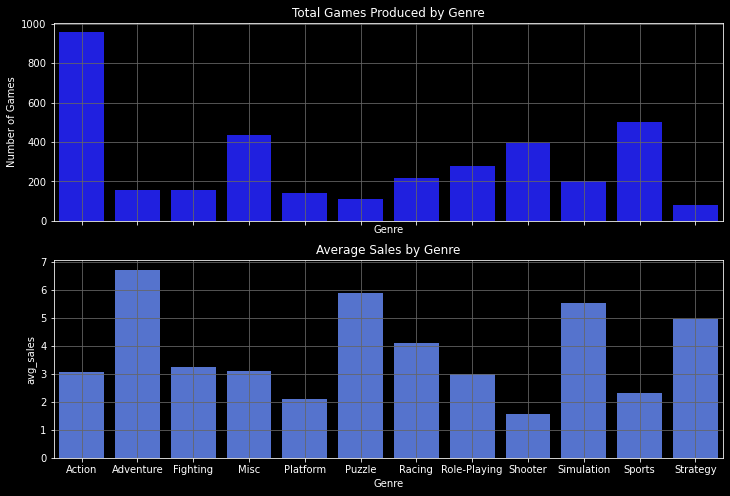

In [117]:
games_by_genre_total = std_vgs_df.groupby(['Genre'])[['dummy','NA_Sales']].sum()
games_by_genre_total['avg_sales'] = games_by_genre_total['dummy'].div(games_by_genre_total['NA_Sales'])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sb.barplot(ax = axes[0], x = games_by_genre_total.index, y=games_by_genre_total['dummy'], color = 'blue')
sb.barplot(ax = axes[1], x = games_by_genre_total.index, y=games_by_genre_total['avg_sales'], color = 'royalblue')

axes[0].set_title('Total Games Produced by Genre')
axes[1].set_title('Average Sales by Genre')
axes[0].set_ylabel('Number of Games')
axes[0].grid(b = True, color = '#666666')
axes[1].grid(b = True, color = '#666666')

Text(0.5, 1.0, 'Average Sales by Publisher per Game')

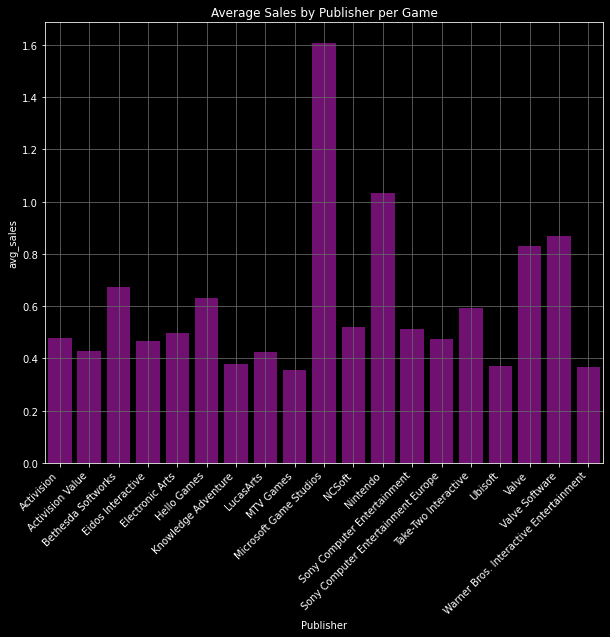

In [13]:
publisher_df = std_vgs_df.groupby(['Publisher'])[['dummy','NA_Sales']].sum()
publisher_df['avg_sales'] = publisher_df['NA_Sales'].div(publisher_df['dummy'])
avg_publisher_df = publisher_df[publisher_df['avg_sales']>= 0.355014] ##top 20 publishers

fig, axes = plt.subplots(1, 1, figsize=(10, 9), sharex=True)

sb.barplot(x = avg_publisher_df.index, y= avg_publisher_df['avg_sales'], color = 'purple')

fig.autofmt_xdate()
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
axes.grid(b = True, color = '#666666')
axes.set_title('Average Sales by Publisher per Game')


In [14]:
std_vgs_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Rating,dummy,General_Platform
0,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo,E,1.0,Nintendo
1,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,Nintendo,E,1.0,Nintendo
2,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,Good Science Studio,E,1.0,Microsoft_Xbox
3,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,Nintendo,E,1.0,Nintendo
4,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,Rockstar North,M,1.0,Sony_Playstation


# Naive Bayes Set-Up

In [73]:
std_vgs_df['NA_Sales'] = np.log(std_vgs_df['NA_Sales'])

count    3616.000000
mean       -1.919475
std         1.262728
min        -4.605170
25%        -2.659260
50%        -1.966113
75%        -1.108663
max         2.747912
Name: NA_Sales, dtype: float64

In [106]:
# find the 50th percentile marker so we can choose games that are above aka 'Sold Well' and games that below aka 'Sold Poorly'
midpoint_sales = std_vgs_df['NA_Sales'].describe()['50%'] ## this midpoint is the .5 quartile marker, so better than this is better than half of all the games produced

#here we are looking at the probablities of particular attributes depending on whether the games end up selling well or poorly
#setting up the genre data analysis df where we will look at what genre will provide highest probability for game success
genre_sales_analysis = pd.DataFrame(std_vgs_df[std_vgs_df['NA_Sales'] > midpoint_sales].groupby('Genre')['NA_Sales'].count()).rename(columns = {'NA_Sales': 'Sold Well'})
genre_sales_analysis = pd.concat([genre_sales_analysis, std_vgs_df[std_vgs_df['NA_Sales'] <= midpoint_sales].groupby('Genre')['NA_Sales'].count().to_frame()], axis=1).rename(columns = {'NA_Sales': 'Sold Poorly'})
genre_sales_analysis = genre_sales_analysis.fillna(0)
genre_sales_analysis['Total Sold'] = genre_sales_analysis['Sold Well'] + genre_sales_analysis['Sold Poorly']
genre_sales_analysis['P Sold Well'] = genre_sales_analysis['Sold Well'] / genre_sales_analysis['Total Sold']
genre_sales_analysis['P Sold Poorly'] = genre_sales_analysis['Sold Poorly'] / genre_sales_analysis['Total Sold']
genre_sales_analysis['Type'] = 'Genre'

#setting up the publisher data analysis df where we will look at what publishers will provide highest probability for game success
publisher_sales_analysis = pd.DataFrame(std_vgs_df[std_vgs_df['NA_Sales'] > midpoint_sales].groupby('Publisher')['NA_Sales'].count()).rename(columns = {'NA_Sales': 'Sold Well'})
publisher_sales_analysis = pd.concat([publisher_sales_analysis, std_vgs_df[std_vgs_df['NA_Sales'] <= midpoint_sales].groupby('Publisher')['NA_Sales'].count().to_frame()], axis=1).rename(columns = {'NA_Sales': 'Sold Poorly'})
publisher_sales_analysis = publisher_sales_analysis.fillna(0)
publisher_sales_analysis['Total Sold'] = publisher_sales_analysis['Sold Well'] + publisher_sales_analysis['Sold Poorly']
publisher_sales_analysis['P Sold Well'] = publisher_sales_analysis['Sold Well'] / publisher_sales_analysis['Total Sold']
publisher_sales_analysis['P Sold Poorly'] = publisher_sales_analysis['Sold Poorly'] / publisher_sales_analysis['Total Sold']
publisher_sales_analysis['Type'] = 'Publisher'
publisher_sales_analysis = publisher_sales_analysis.loc[publisher_sales_analysis['Total Sold'] >= publisher_sales_analysis['Total Sold'].describe()['50%']]

#setting up the developer data analysis df where we will look at what developers will provide highest probability for game success
developer_sales_analysis = pd.DataFrame(std_vgs_df[std_vgs_df['NA_Sales'] > midpoint_sales].groupby('Developer')['NA_Sales'].count()).rename(columns = {'NA_Sales': 'Sold Well'})
developer_sales_analysis = pd.concat([developer_sales_analysis, std_vgs_df[std_vgs_df['NA_Sales'] <= midpoint_sales].groupby('Developer')['NA_Sales'].count().to_frame()], axis=1).rename(columns = {'NA_Sales': 'Sold Poorly'})
developer_sales_analysis = developer_sales_analysis.fillna(0)
developer_sales_analysis['Total Sold'] = developer_sales_analysis['Sold Well'] + developer_sales_analysis['Sold Poorly']
developer_sales_analysis['P Sold Well'] = developer_sales_analysis['Sold Well'] / developer_sales_analysis['Total Sold']
developer_sales_analysis['P Sold Poorly'] = developer_sales_analysis['Sold Poorly'] / developer_sales_analysis['Total Sold']
developer_sales_analysis['Type'] = 'Developer'
#have to adjust for indie games, so we added a requirment for developers to have made atleast 8 games
developer_sales_analysis = developer_sales_analysis.loc[developer_sales_analysis['Total Sold'] >= 8.0]#developer_sales_analysis['Total Sold'].describe()['75%']]

#setting up the platform data analysis df where we will look at what platforms will provide highest probability for game success
platform_sales_analysis = pd.DataFrame(std_vgs_df[std_vgs_df['NA_Sales'] > midpoint_sales].groupby('Platform')['NA_Sales'].count()).rename(columns = {'NA_Sales': 'Sold Well'})
platform_sales_analysis = pd.concat([platform_sales_analysis, std_vgs_df[std_vgs_df['NA_Sales'] <= midpoint_sales].groupby('Platform')['NA_Sales'].count().to_frame()], axis=1).rename(columns = {'NA_Sales': 'Sold Poorly'})
platform_sales_analysis = platform_sales_analysis.fillna(0)
platform_sales_analysis['Total Sold'] = platform_sales_analysis['Sold Well'] + platform_sales_analysis['Sold Poorly']
platform_sales_analysis['P Sold Well'] = platform_sales_analysis['Sold Well'] / platform_sales_analysis['Total Sold']
platform_sales_analysis['P Sold Poorly'] = platform_sales_analysis['Sold Poorly'] / platform_sales_analysis['Total Sold']
platform_sales_analysis['Type'] = 'Platform'

#concatenate the 10 top attributes by probability from each of our four columns that we will be using to train our naive bayers model
naive_bayes_probablities = pd.concat([genre_sales_analysis.nlargest(10, columns = 'P Sold Well'), publisher_sales_analysis.nlargest(10, columns = 'P Sold Well'), developer_sales_analysis.nlargest(10, columns = 'P Sold Well'), platform_sales_analysis.nlargest(10, columns = 'P Sold Well')])

In [107]:
naive_bayes_probablities

,Sold Well,Sold Poorly,Total Sold,P Sold Well,P Sold Poorly,Type
Shooter,230.0,162.0,392.0,0.586735,0.413265,Genre
Fighting,91.0,65.0,156.0,0.583333,0.416667,Genre
Sports,282.0,217.0,499.0,0.565130,0.434870,Genre
Role-Playing,136.0,141.0,277.0,0.490975,0.509025,Genre
Action,467.0,490.0,957.0,0.487983,0.512017,Genre
Misc,205.0,228.0,433.0,0.473441,0.526559,Genre
Platform,62.0,79.0,141.0,0.439716,0.560284,Genre
Racing,80.0,134.0,214.0,0.373832,0.626168,Genre
Simulation,70.0,131.0,201.0,0.348259,0.651741,Genre
Strategy,27.0,53.0,80.0,0.337500,0.662500,Genre


In [103]:
#calculate the probability of the sales of a game being above the midpoint before modeling
base_probability = std_vgs_df[std_vgs_df['NA_Sales']> midpoint_sales]['NA_Sales'].size / std_vgs_df['NA_Sales'].size

#create a simple dummy column that will be used as our target in the gaussian naive bayes model
std_vgs_df['good_or_bad'] = np.zeros(std_vgs_df['NA_Sales'].size, dtype = 'int8')
std_vgs_df.loc[std_vgs_df['NA_Sales'] > midpoint_sales, 'good_or_bad'] = int(1)


#processing are categorical data and making dummy columns in order to train our model        
tempor1 = pd.get_dummies(std_vgs_df.Genre, prefix = 'Genre')
tempor2 = pd.get_dummies(std_vgs_df.Publisher, prefix = 'Publisher')
tempor3 = pd.get_dummies(std_vgs_df.Developer, prefix = 'Developer')
tempor4 = pd.get_dummies(std_vgs_df.Platform, prefix = 'Platform')

std_vgs_df = pd.concat([std_vgs_df, tempor1, tempor2, tempor3, tempor4], axis = 1)

final_data = std_vgs_df.drop(['good_or_bad','Name', 'Platform', 'Year_of_Release','Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer', 'Rating', 'dummy', 'General_Platform'], axis=1)

#our full dataset
X = final_data.reset_index(drop = True)
y = np.array(std_vgs_df.good_or_bad.values)

## Gaussian Naive Bayes Cross Validation with MapReduce based algorithm

In [104]:
## Here is where we see how accurate our Naive Bayes Model is for predicting whether or not the sales of a game will be in top 50th percentile
def get_scores(data_lis, return_lis):
    # acts as a MAPPER as our Naive Bayes model is training itself from two inputs (dataframe and array) and returning a list of predictions
    y_pred = gnb.fit(data_lis[0], data_lis[2]).predict(data_lis[1])
    # acts as REDUCER because it is taking the list of predictions as input and outputting a float value that is the accuracy score
    return_lis.append(accuracy_score(data_lis[3], y_pred))

# number of folds for our cross validation
kfolds = 6

#split the data into training and test set while shuffling the training set in kfolds, returns a bunch of 1D arrays of indexes
shuffle = StratifiedShuffleSplit(n_splits = kfolds, test_size = 0.3, random_state = 2)
shuffled_data = shuffle.split(X, y)

#initialize our Gaussian Naive Bayes Model
gnb = GaussianNB()

#using the lists of indexes to prepare subsets of train and test data for parallel computing
#output is a list of lists that each contain 4 pieces of data for each kfold: X_train, X_test, y_train, y_test
list_of_splits = []
for train_index, test_index in shuffled_data:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    full_set = [X_train, X_test, y_train, y_test]
    list_of_splits.append(full_set)
    
#run the get_scores method in parallel for each of the kfolds and combine the scores in a list    
processes = []
if __name__ == '__main__':
    final_list= []
    manager = multiprocessing.Manager()
    final_list = manager.list()

    for i in range(kfolds):
        p = multiprocessing.Process(target = get_scores(list_of_splits[i],final_list))
        p.start()
        processes.append(p)
    for pro in processes:
        pro.join()

#accuracy scores from all folds
list_of_scores = list(final_list)

In [105]:
print('The probability of a game\'s sales to be in the top 50th percentile before modeling is : %f'
      % (base_probability))
print('These are our results from cross validation : ', list_of_scores)
print('The average score for our models in our cross validation of %d folds : %f with a standard deviation of %f'
      % (kfolds, sum(list_of_scores)/len(list_of_scores), pstdev(list_of_scores)))

The probability of a game's sales to be in the top 50th percentile before modeling is : 0.477046
These are our results from cross validation :  [0.5889400921658986, 0.6064516129032258, 0.5926267281105991, 0.5732718894009217, 0.5926267281105991, 0.6064516129032258]
The average score for our models in our cross validation of 6 folds : 0.593395 with a standard deviation of 0.011306
